In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def median_scale(x):
    """
    Calculating the median bandwidth parameter of the RBF kernel

    Parameters:
        - x: A tensor of shape (N, D)

    Return:
        - scale: The bandwidth of the RBF kernel using the median trick.
    """

    x_norm = (x ** 2).sum(1).view(-1, 1)
    dist = x_norm + x_norm.t() - 2.0 * torch.mm(x, x.t())
    dist = dist - torch.diag(torch.diag(dist))  # Set the diagonal element to 0
    scale = dist.view(-1).median().sqrt()

    return scale

def compute_mmd(x, y, kernel='rbf', **kwargs):
    """
    Compute the Maximum Mean Discrepancy (MMD) between two sets of samples, x and y.

    Parameters:
        - x: First set of samples. Shape: (n, d)
        - y: Second set of samples. Shape: (m, d)
        - kernel: Type of kernel to be used. Currently supports 'rbf', 'imq', 'linear', and 'cosine'.
        - **kwargs: Additional keyword arguments for the kernel functions.

    Returns:
        - mmd: The MMD value between x and y.
    """

    def rbf_kernel(x, y, bandwidth=1.0):
        x = x.unsqueeze(1)  # Shape: (n, 1, d)
        y = y.unsqueeze(0)  # Shape: (1, m, d)
        
        # Compute pairwise distances
        distances = (x - y).pow(2).sum(-1)

        return torch.exp(-distances / (2 * bandwidth * bandwidth))

    def imq_kernel(x, y, c=1.0):
        x = x.unsqueeze(1)  # Shape: (n, 1, d)
        y = y.unsqueeze(0)  # Shape: (1, m, d)

        # Compute pairwise distances
        distances = (x - y).pow(2).sum(-1)
        
        return c * c / (c * c + distances)

    def linear_kernel(x, y):
        return torch.mm(x, y.t())

    def cosine_similarity_kernel(x, y):
        x_norm = x / (x.norm(p=2, dim=1, keepdim=True) + 1e-8)
        y_norm = y / (y.norm(p=2, dim=1, keepdim=True) + 1e-8)
        return torch.mm(x_norm, y_norm.t())

    if kernel == 'rbf':
        kernel_func = rbf_kernel
    elif kernel == 'imq':
        kernel_func = imq_kernel
    elif kernel == 'linear':
        kernel_func = linear_kernel
    elif kernel == 'cosine':
        kernel_func = cosine_similarity_kernel
    else:
        raise ValueError("Unsupported kernel type.")

    with torch.no_grad():
        # Compute individual kernel matrices
        xx_kernel = kernel_func(x, x, **kwargs).mean()
        yy_kernel = kernel_func(y, y, **kwargs).mean()
        xy_kernel = kernel_func(x, y, **kwargs).mean()

    # Compute MMD
    mmd = xx_kernel + yy_kernel - 2 * xy_kernel
    return mmd


In [3]:
# Gold Standard
gs = np.loadtxt('AnnulusGaussianMixture.csv', delimiter=',')

# DDPG
DDPG_mcmc_2D_cov_small_total = np.loadtxt('AnnulusGaussianMixture_DDPG_small.csv', delimiter=',')
DDPG_mcmc_2D_cov_small_burnin = DDPG_mcmc_2D_cov_small_total[-10_000:-1, :]

DDPG_mcmc_2D_cov_medium_total = np.loadtxt('AnnulusGaussianMixture_DDPG_medium.csv', delimiter=',')
DDPG_mcmc_2D_cov_medium_burnin = DDPG_mcmc_2D_cov_small_total[-10_000:-1, :]

DDPG_mcmc_2D_cov_large_total = np.loadtxt('AnnulusGaussianMixture_DDPG_large.csv', delimiter=',')
DDPG_mcmc_2D_cov_large_burnin = DDPG_mcmc_2D_cov_small_total[-10_000:-1, :]

# MALA
MALA_total = np.loadtxt('AnnulusGaussianMixture_MALA.csv', delimiter=',')
MALA_burnin = MALA_total[-10_000:-1, :]

fisher_MALA_total = np.loadtxt('AnnulusGaussianMixture_fisher_MALA.csv', delimiter=',')
fisher_MALA_burnin = fisher_MALA_total[-10_000:-1, :]

# MH
rwm_total = np.loadtxt('AnnulusGaussianMixture_rwm.csv', delimiter=',')
rwm_burnin = rwm_total[-10_000:-1, :]

# NUTS
NUTS_1c_total = np.loadtxt('AnnulusGaussianMixture_NUTS_1c.csv', delimiter=',')
NUTS_1c_burnin = NUTS_1c_total[-10_000:-1, :]

NUTS_4c_total = np.loadtxt('AnnulusGaussianMixture_NUTS_4c.csv', delimiter=',')
NUTS_4c_burnin = NUTS_4c_total[-10_000:-1, :]

In [4]:
# Convert to torch GPU tensor

# Gold Standard
gs_gpu = torch.from_numpy(gs).to('cuda').half()

# DDPG
DDPG_mcmc_2D_cov_small_gpu = torch.from_numpy(DDPG_mcmc_2D_cov_small_burnin).to('cuda').half()
DDPG_mcmc_2D_cov_medium_gpu = torch.from_numpy(DDPG_mcmc_2D_cov_medium_burnin).to('cuda').half()
DDPG_mcmc_2D_cov_large_gpu = torch.from_numpy(DDPG_mcmc_2D_cov_large_burnin).to('cuda').half()

# MALA
MALA_gpu = torch.from_numpy(MALA_burnin).to('cuda').half()
fisher_MALA_gpu = torch.from_numpy(fisher_MALA_burnin).to('cuda').half()

# MH
rwm_gpu = torch.from_numpy(rwm_burnin).to('cuda').half()

# NUTS
NUTS_1c_gpu = torch.from_numpy(NUTS_1c_burnin).to('cuda').half()
NUTS_4c_gpu = torch.from_numpy(NUTS_4c_burnin).to('cuda').half()

# Compute Bandwidth
DDPG_mcmc_2D_cov_small_scale = median_scale(DDPG_mcmc_2D_cov_small_gpu)
DDPG_mcmc_2D_cov_medium_scale = median_scale(DDPG_mcmc_2D_cov_medium_gpu)
DDPG_mcmc_2D_cov_large_scale = median_scale(DDPG_mcmc_2D_cov_large_gpu)

MALA_scale = median_scale(MALA_gpu)
fisher_MALA_scale = median_scale(fisher_MALA_gpu)

rwm_scale = median_scale(rwm_gpu)

NUTS_1c_scale = median_scale(NUTS_1c_gpu)
NUTS_4c_scale = median_scale(NUTS_4c_gpu)

# Store MMD
DDPG_mcmc_2D_cov_small_MMD = []
DDPG_mcmc_2D_cov_medium_MMD = []
DDPG_mcmc_2D_cov_large_MMD = []

MALA_MMD = []
fisher_MALA_MMD = []

rwm_MMD = []

NUTS_1c_MMD = []
NUTS_4c_MMD = []

In [5]:
for i in [1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000]:
    DDPG_mcmc_2D_cov_small_mmd_value = compute_mmd(gs_gpu, DDPG_mcmc_2D_cov_small_gpu[0:i], kernel='rbf', bandwidth=DDPG_mcmc_2D_cov_small_scale)
    DDPG_mcmc_2D_cov_small_MMD.append(DDPG_mcmc_2D_cov_small_mmd_value)
    del DDPG_mcmc_2D_cov_small_mmd_value

    DDPG_mcmc_2D_cov_medium_mmd_value = compute_mmd(gs_gpu, DDPG_mcmc_2D_cov_medium_gpu[0:i], kernel='rbf', bandwidth=DDPG_mcmc_2D_cov_medium_scale)
    DDPG_mcmc_2D_cov_medium_MMD.append(DDPG_mcmc_2D_cov_medium_mmd_value)
    del DDPG_mcmc_2D_cov_medium_mmd_value

    DDPG_mcmc_2D_cov_large_mmd_value = compute_mmd(gs_gpu, DDPG_mcmc_2D_cov_large_gpu[0:i], kernel='rbf', bandwidth=DDPG_mcmc_2D_cov_large_scale)
    DDPG_mcmc_2D_cov_large_MMD.append(DDPG_mcmc_2D_cov_large_mmd_value)
    del DDPG_mcmc_2D_cov_large_mmd_value

    MALA_mmd_value = compute_mmd(gs_gpu, MALA_gpu[0:i], kernel='rbf', bandwidth=MALA_scale)
    MALA_MMD.append(MALA_mmd_value)
    del MALA_mmd_value

    fisher_MALA_mmd_value = compute_mmd(gs_gpu, fisher_MALA_gpu[0:i], kernel='rbf', bandwidth=fisher_MALA_scale)
    fisher_MALA_MMD.append(fisher_MALA_mmd_value)
    del fisher_MALA_mmd_value

    rwm_mmd_value = compute_mmd(gs_gpu, rwm_gpu[0:i], kernel='rbf', bandwidth=rwm_scale)
    rwm_MMD.append(rwm_mmd_value)
    del rwm_mmd_value

    NUTS_1c_mmd_value = compute_mmd(gs_gpu, NUTS_1c_gpu[0:i], kernel='rbf', bandwidth=NUTS_1c_scale)
    NUTS_1c_MMD.append(NUTS_1c_mmd_value)
    del NUTS_1c_mmd_value

    NUTS_4c_mmd_value = compute_mmd(gs_gpu, NUTS_4c_gpu[0:i], kernel='rbf', bandwidth=NUTS_4c_scale)
    NUTS_4c_MMD.append(NUTS_4c_mmd_value)
    del NUTS_4c_mmd_value


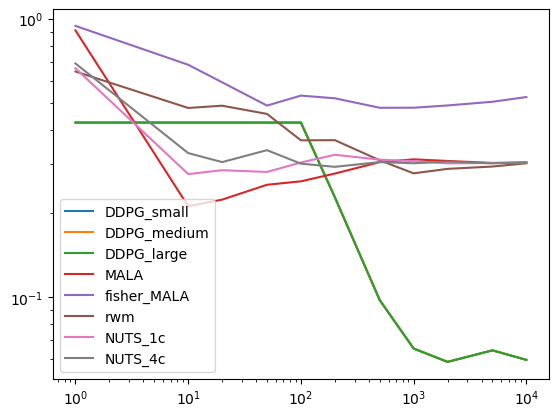

In [6]:
plt.loglog(np.array([1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000]), np.array([i.to('cpu').numpy() for i in DDPG_mcmc_2D_cov_small_MMD]), label='DDPG_small')
plt.loglog(np.array([1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000]), np.array([i.to('cpu').numpy() for i in DDPG_mcmc_2D_cov_medium_MMD]), label='DDPG_medium')
plt.loglog(np.array([1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000]), np.array([i.to('cpu').numpy() for i in DDPG_mcmc_2D_cov_large_MMD]), label='DDPG_large')

plt.loglog(np.array([1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000]), np.array([i.to('cpu').numpy() for i in MALA_MMD]), label='MALA')
plt.loglog(np.array([1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000]), np.array([i.to('cpu').numpy() for i in fisher_MALA_MMD]), label='fisher_MALA')

plt.loglog(np.array([1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000]), np.array([i.to('cpu').numpy() for i in rwm_MMD]), label='rwm')

plt.loglog(np.array([1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000]), np.array([i.to('cpu').numpy() for i in NUTS_1c_MMD]), label='NUTS_1c')
plt.loglog(np.array([1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000]), np.array([i.to('cpu').numpy() for i in NUTS_4c_MMD]), label='NUTS_4c')

plt.legend()
plt.savefig('AnnulusGaussianMixture_MMD.png', dpi=600)